# 5.1 Trial 1

### Required Modules

In [114]:
# Basic Operations
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Loading Datasets

In [79]:
# Original Data
raw_data = pd.read_csv("data/training-set-1/pose_data_raw.csv")
raw_data['label'] = raw_data['pose_name'].str.replace('-lft', '').str.replace('-rgt', '')
labels, uniques = pd.factorize(raw_data['label'])
raw_data['label_encoded'] = labels

Xr = raw_data.iloc[:,2:134]
yr = raw_data['label_encoded'].values

# Augmented Data with Features
aug_data = pd.read_csv("data/training-set-1/pose_data_res.csv")
aug_data['label'] = aug_data['pose_name'].str.replace('-lft', '').str.replace('-rgt', '')
labels2, uniques2 = pd.factorize(aug_data['label'])
aug_data['label_encoded'] = labels2

Xa = aug_data.iloc[:,2:-2]
ya = aug_data['label_encoded'].values
pose_names = aug_data['label'].values

#Scaled Data
scaler = StandardScaler()
Xr_scaled = scaler.fit_transform(Xr)
Xa_scaled = scaler.fit_transform(Xa)

## 4.1 Cross-Validation Scores

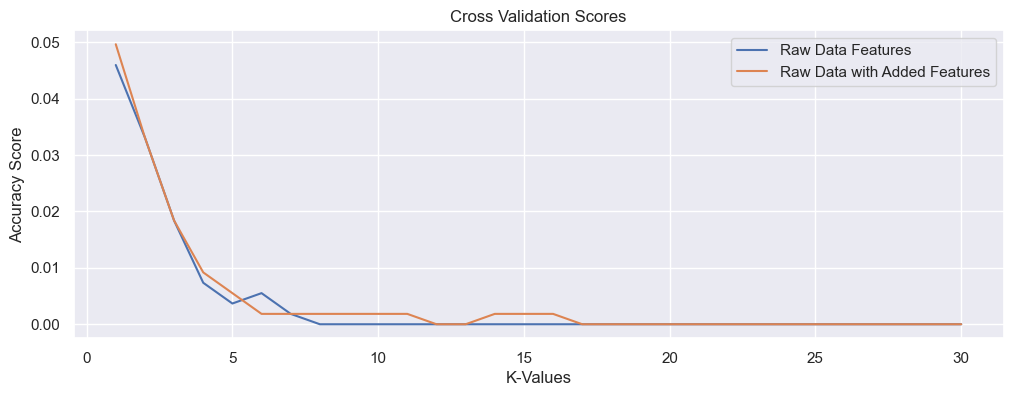

In [121]:
k_values = [i for i in range(1, 31)]

scores_Xr = []
scores_Xa = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score_Xr = cross_val_score(knn, Xr_scaled, y, cv=LeaveOneOut(), scoring='accuracy')
    scores_Xr.append(np.mean(score_Xr))
    score_Xa = cross_val_score(knn, Xa_scaled, y, cv=LeaveOneOut(), scoring='accuracy')
    scores_Xa.append(np.mean(score_Xa))

sns.set(rc={'figure.figsize':(12,4)})
sns.lineplot(x = k_values, y = scores_Xr, label='Raw Data Features')
sns.lineplot(x = k_values, y = scores_Xa, label='Raw Data with Added Features')
plt.title("Cross Validation Scores")
plt.xlabel('K-Values')
plt.ylabel('Accuracy Score')
plt.show()

In [83]:
# Find index of maximum accuracy for raw data
idx_max_Xr = np.argmax(scores_Xr)
optimal_k_Xr = k_values[idx_max_Xr]
max_accuracy_Xr = scores_Xr[idx_max_Xr]

# Find index of maximum accuracy for augmented data
idx_max_Xa = np.argmax(scores_Xa)
optimal_k_Xa = k_values[idx_max_Xa]
max_accuracy_Xa = scores_Xa[idx_max_Xa]

print(f"Optimal K (Raw Data): {optimal_k_Xr} - Maximum Accuracy: {max_accuracy_Xr:.4f}")
print(f"Optimal K (Augmented Data): {optimal_k_Xa} - Maximum Accuracy: {max_accuracy_Xa:.4f}")

Optimal K (Raw Data): 1 - Maximum Accuracy: 0.0460
Optimal K (Augmented Data): 1 - Maximum Accuracy: 0.0496


## 4.2 Dimensionality Reduction Methods

Through dimensionality reduction methods, we aim to validate the contribution of features by transforming the data to a space where the most significant variances in PCA and class separability using LDA.

### 4.2.1 Principal Component Analysis

A scree plot analysis is instrumental in understanding the distribution of variance across principal components in high-dimensional data. The "elbow" in the plot typically represents the point beyond which additional components have a diminishing return on explaining the variance.

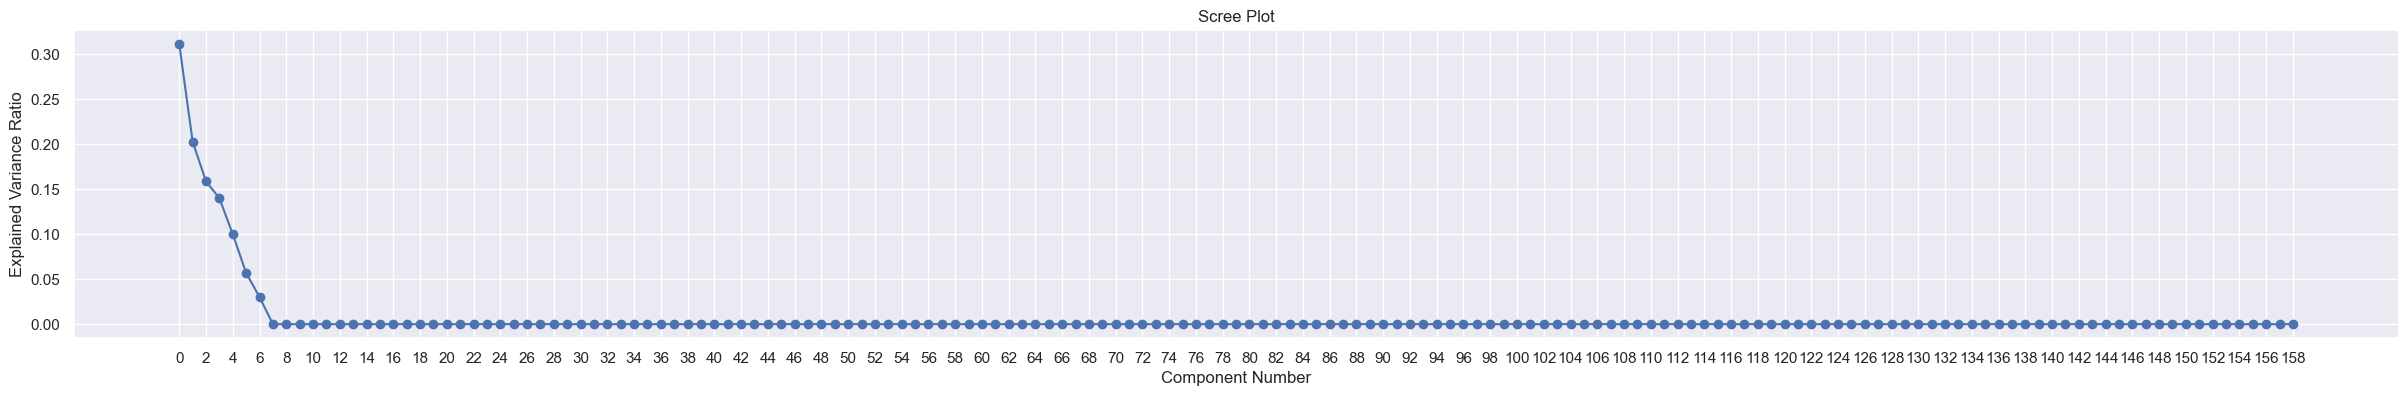

In [122]:
pca = PCA()
Xa_pca = pca.fit_transform(Xa)

explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_  

sns.set(rc={'figure.figsize':(30,4)})
plt.plot(explained_variance_ratio, marker='o')
plt.xticks(range(len(explained_variance_ratio))[::2])
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

Multiple inflection points can be observed in the scree plot, but we would focus on the first two which occurs between 0 - 4 components. To understand its variance, we use a pair plot to see the direction. 

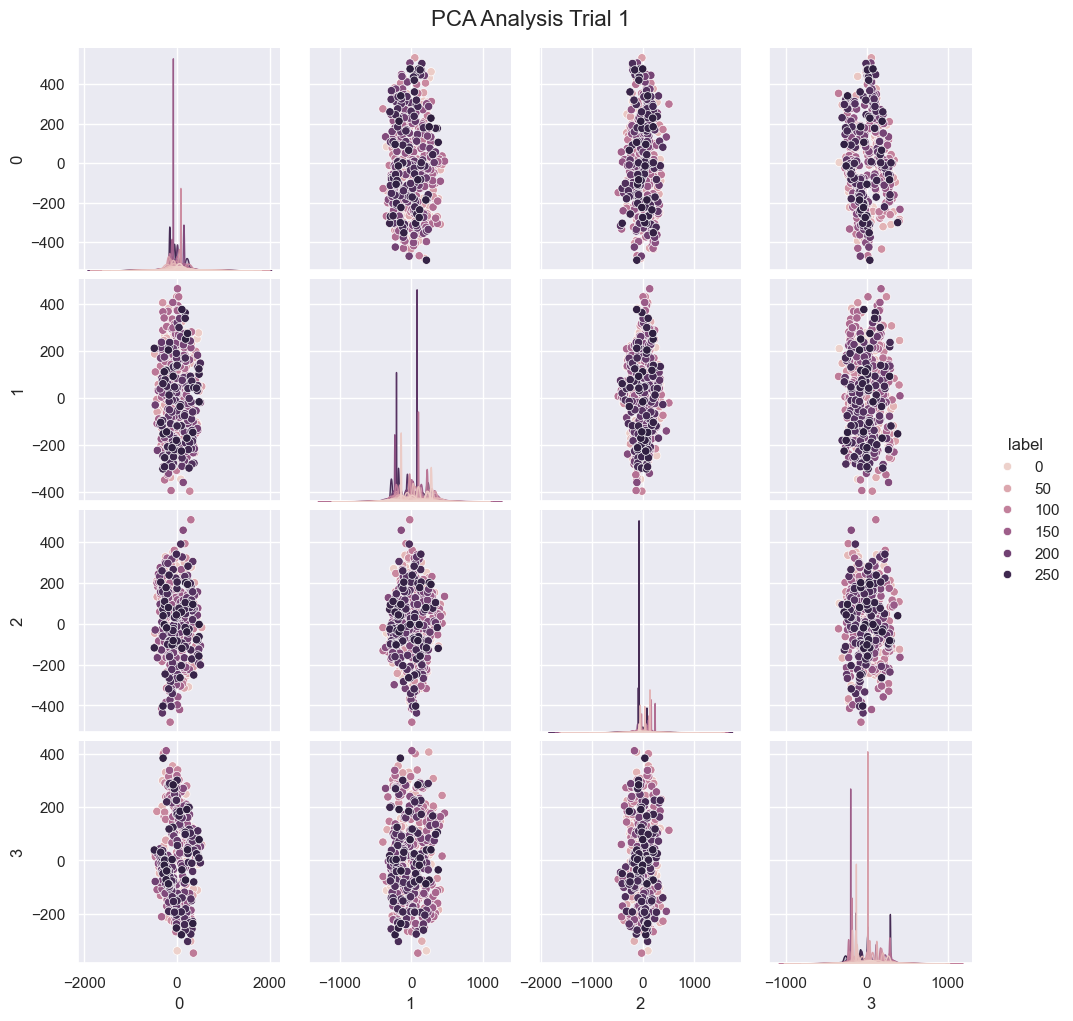

In [128]:
pca = PCA(n_components=4)
Xa_pca = pca.fit_transform(Xa)
pca_res = pd.DataFrame(data = Xa_pca)
pca_res['label'] = ya

pairplot_fig = sns.pairplot(pca_res, hue='label')
pairplot_fig.fig.suptitle('PCA Analysis Trial 1', size=16, y=1.02)
pairplot_fig.savefig("trial1_feature_validation_pca_pairplot.png")
plt.show()

### 4.2.2 Linear Discriminant Analysis

Since there are only 2 data points per unique class, it is not recommended to conduct this analysis.

## 4.3 KNN Classification Prediction

### 4.3.1 PCA-Reduced Training and Test Split

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


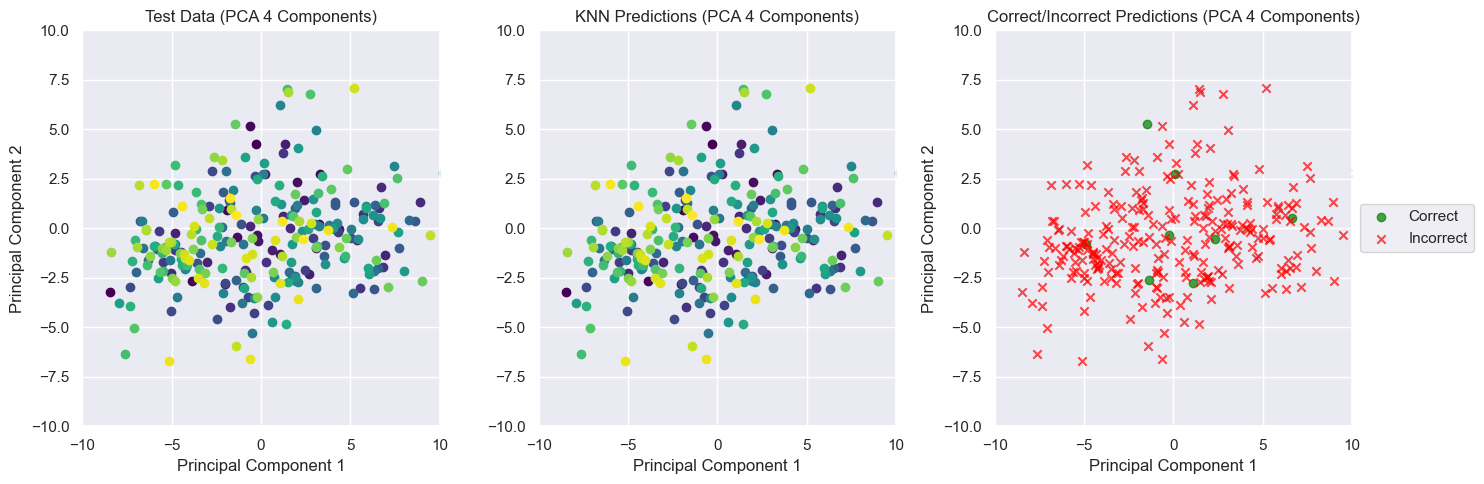

In [119]:
def pca_reduced_knn_training_validation(X,y,pose_names,n_components,n_neighbors,test_size):
    unique_poses = np.unique(pose_names)
    color_values = cm.viridis(np.linspace(0, 1, num=len(unique_poses)))
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test, pose_names_train, pose_names_test = train_test_split(X_scaled, y, pose_names, stratify=y, test_size=test_size)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, pose in enumerate(unique_poses):
        idx = pose_names_test == pose
        axes[0].scatter(X_test_pca[idx, 0], X_test_pca[idx, 1], color=color_values[i], label=pose)
    axes[0].set_title(f'Test Data (PCA {n_components} Components)')
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    axes[0].grid(True)
    axes[0].set_xlim([-10, 10])
    axes[0].set_ylim([-10, 10])

    # Predictions Plot
    for i, pose in enumerate(unique_poses):
        idx = pose_names_test == pose
        axes[1].scatter(X_test_pca[idx, 0], X_test_pca[idx, 1], color=color_values[i], label=pose)
    axes[1].set_title(f'KNN Predictions (PCA {n_components} Components)')
    axes[1].set_xlabel('Principal Component 1')
    axes[1].grid(True)
    axes[1].set_xlim([-10, 10])
    axes[1].set_ylim([-10, 10])

    # True Labels Plot
    correct = y_pred == y_test
    incorrect = ~correct
    axes[2].scatter(X_test_pca[correct, 0], X_test_pca[correct, 1], c='green', marker='o', alpha=0.7, label='Correct')
    axes[2].scatter(X_test_pca[incorrect, 0], X_test_pca[incorrect, 1], c='red', marker='x', alpha=0.7, label='Incorrect')
    axes[2].set_title(f'Correct/Incorrect Predictions (PCA {n_components} Components)')
    axes[2].set_xlabel('Principal Component 1')
    axes[2].set_ylabel('Principal Component 2')
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[2].grid(True)
    axes[2].set_xlim([-10, 10])
    axes[2].set_ylim([-10, 10])
        
    if len(unique_poses) < 11:
        axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fontsize='small', ncol=2)
        
    plt.tight_layout()
    plt.show()
    
    return accuracy, precision, recall, f1, conf_matrix
    
accuracy, precision, recall, f1, conf_matrix = pca_reduced_knn_training_validation(Xr,yr,pose_names, n_neighbors=1, n_components=4, test_size=0.5)

In [120]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.0294
Precision: 0.0205
Recall: 0.0294
F1 Score: 0.0229


## Trial 1 Findings

Due to the current limitation of having only two samples for each of the 272 classes, the accuracy of the model is insufficient for conducting reliable further analysis. In order to validate the features effectively and improve the model's performance, it is imperative to augment the dataset. The implementation of synthetic data generation techniques is recommended to increase the volume of data per class. Additionally, conducting feature importance experiments will be beneficial in evaluating the impact of newly added features on the model's accuracy. This approach will not only help in enhancing the model's performance but also provide deeper insights into the relevance and contribution of each feature towards the classification task.